In [55]:
import numpy as np 
import pandas as pd 
from nltk.corpus import stopwords
import nltk
import string
from nltk import word_tokenize
import re
import gensim
import pyLDAvis.gensim
from gensim.models import word2vec
from nltk.corpus import wordnet
from wordcloud import WordCloud
from spacy import displacy
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
stop = stopwords.words('english')
from imp import reload
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cyberbullying-detection-dataset/twitter_parsed_dataset.csv


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [53]:
import transformers

In [2]:
import spacy
nlp = spacy.load("en_core_web_sm")

## Load the dataset

In [3]:
df = pd.read_csv("/kaggle/input/cyberbullying-detection-dataset/twitter_parsed_dataset.csv")
df

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0
...,...,...,...,...,...
16846,5.75606766236475E+017,5.75606766236475E+017,"Feeling so sorry for the girls, they should be...",none,0.0
16847,5.72333822886326E+017,5.72333822886326E+017,#MKR 'pretty good dishes we're happy with' - O...,none,0.0
16848,5.72326950057845E+017,5.72326950057845E+017,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0
16849,5.74799612642357E+017,5.74799612642357E+017,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0


## Data Understannding

0.0    11501
1.0     5347
Name: oh_label, dtype: int64


<AxesSubplot:>

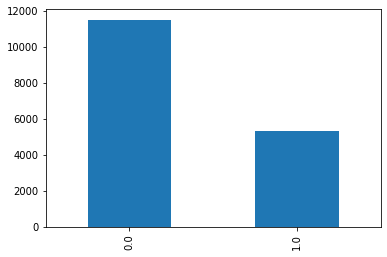

In [4]:
print(df['oh_label'].value_counts())
df['oh_label'].value_counts().plot(kind='bar')

- This is an imbalance class classification problem to classify wheather the tweet was bullying or not.

In [5]:
df.describe(include='O')

,index,id,Text,Annotation
count,16851,16850,16850,16848
unique,16851,16850,16850,3
top,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none
freq,1,1,1,11501


In [6]:
df.describe()

,oh_label
count,16848.000000
mean,0.317367
std,0.465465
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
df['Annotation'].value_counts()

none      11501
sexism     3377
racism     1970
Name: Annotation, dtype: int64

**Insights:**

- Bullying tweets are annotated as either sexism or racism
- Out of 5347 tweets we have 3377 tweets annoted as a sexism and 1970 tweets annoted as a racism

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16851 entries, 0 to 16850
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       16851 non-null  object 
 1   id          16850 non-null  object 
 2   Text        16850 non-null  object 
 3   Annotation  16848 non-null  object 
 4   oh_label    16848 non-null  float64
dtypes: float64(1), object(4)
memory usage: 658.4+ KB


- There are few rows having null values. we will drop them
- We can also drop index and id columns as they are not needed

In [9]:
# drop the unnecessary columns
ndf = df.drop(['index','id'], axis=1)
ndf.dropna(inplace=True)
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16848 entries, 0 to 16850
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Text        16848 non-null  object 
 1   Annotation  16848 non-null  object 
 2   oh_label    16848 non-null  float64
dtypes: float64(1), object(2)
memory usage: 526.5+ KB


In [10]:
ndf.oh_label.value_counts()

0.0    11501
1.0     5347
Name: oh_label, dtype: int64

In [11]:
# unprocessed dataframe to perform pre-processing and feature extraction to get final text corpus
ndf.head()

,Text,Annotation,oh_label
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,#mkr No No No No No No,none,0.0


## Text cleaning and feature extraction

In [12]:
# count the stopwords
ndf['stopwords'] = ndf['Text'].apply(lambda x: len([x for x in x.split() if x in stop]))
ndf[['Text','stopwords']].head()

,Text,stopwords
0,@halalflaws @biebervalue @greenlinerzjm I read...,4
1,@ShreyaBafna3 Now you idiots claim that people...,9
2,"RT @Mooseoftorment Call me sexist, but when I ...",7
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",4
4,#mkr No No No No No No,0


In [13]:
# count the puncutuation
def punct_count(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

ndf['Punc_count'] = ndf['Text'].apply(lambda x: punct_count(x))
ndf[['Text','Punc_count']].head()

,Text,Punc_count
0,@halalflaws @biebervalue @greenlinerzjm I read...,11
1,@ShreyaBafna3 Now you idiots claim that people...,3
2,"RT @Mooseoftorment Call me sexist, but when I ...",4
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",3
4,#mkr No No No No No No,1


In [14]:
# count the hashtags and mentions
ndf['hashtags/mentions'] = ndf['Text'].apply(lambda x: len([x for x in x.split() if x.startswith(('#','@'))]))
ndf[['Text','hashtags/mentions']].head()

,Text,hashtags/mentions
0,@halalflaws @biebervalue @greenlinerzjm I read...,3
1,@ShreyaBafna3 Now you idiots claim that people...,1
2,"RT @Mooseoftorment Call me sexist, but when I ...",1
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1
4,#mkr No No No No No No,1


In [15]:
ndf['hashtags/mentions'].loc[ndf['hashtags/mentions'] != 0].count()

15328

- Out of 16848 documents, 15328 has either hashtag or mention


In [16]:
# find the number of numerics
ndf['numerics'] = ndf['Text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
ndf[['Text','numerics']].head()

,Text,numerics
0,@halalflaws @biebervalue @greenlinerzjm I read...,0
1,@ShreyaBafna3 Now you idiots claim that people...,0
2,"RT @Mooseoftorment Call me sexist, but when I ...",0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",0
4,#mkr No No No No No No,0


In [17]:
# number of documents with digit char
ndf[ndf['numerics'] != 0][['Text','numerics']].shape

(883, 2)

### Text cleaning function

In [18]:
# Now let's clean the text data for further analysis
only_english = set(nltk.corpus.words.words())
def text_cleaning(text):
    """ A function to clean the text data"""
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) # links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

<>:9: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \(
<>:12: DeprecationWarning: invalid escape sequence \w
<>:19: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \(
<>:12: DeprecationWarning: invalid escape sequence \w
<>:19: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \(
<>:12: DeprecationWarning: invalid escape sequence \w
<>:19: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_27/2222851142.py:9: DeprecationWarning: invalid escape sequence \[
  sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
/tmp/ipykernel_27/2222851142.py:10: DeprecationWarning: invalid escape sequence \(
  sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
/tmp/ipykernel_27/2222851142.py:12: DeprecationW

In [19]:
# call the clean function to clean the the data
ndf['cleaned_text'] = ndf['Text'].apply(lambda x: text_cleaning(x))
ndf[['Text','cleaned_text']]

,Text,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,i read them in change in meaning the history o...
1,@ShreyaBafna3 Now you idiots claim that people...,shreyabafna3 now you claim that people who tri...
2,"RT @Mooseoftorment Call me sexist, but when I ...",call me but when i go to an auto place id rath...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",wrong the example of and the exactly
4,#mkr No No No No No No,no no no no no no
...,...,...
16846,"Feeling so sorry for the girls, they should be...",feeling so sorry for the they should be safe a...
16847,#MKR 'pretty good dishes we're happy with' - O...,pretty good were happy with well never eating ...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,lemon we please go just one season of without ...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,you are too stupid to talk to blocked


**Next steps:**

- Stemming, lemmat, stop-word removal, pos tagging
- Topic modeling and NER by annotation
- Clean text feature extraction 
- EDA

In [20]:
# stop word removal function
stopwrds = set(stopwords.words('english'))
def remove_stowords(text, cores=2):
    
    sample = text
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stopwrds]
    sample = ' '.join(sample)
    
    return sample


# get POS Tag for word
def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

# lemmatization function
lemmatizer = WordNetLemmatizer()
def lemma_clean_text(text, cores = 1):
 
    sample = text
    sample = sample.split()
    sample = [lemmatizer.lemmatize(word.lower()) for word in sample]
    sample = ' '.join(sample)
    
    return sample

# stemming of the text data
ps = PorterStemmer()
def stem_clean_text(text):
 
    sample = text
    sample = sample.split()
    sample = [ps.stem(word) for word in sample]
    sample = ' '.join(sample)
    
    return sample

# correct the spelling
def correct_spelling(text):
    
    sample = text
    sample = str(TextBlob(text).correct())
    
    return sample

### POS tagging 

- Parts of speech taggin or POS used to tag or identify components of speech that are used in certain sentense.
- We will use nltk's pos_tagging function for pos identification

In [21]:
def sentense_pos_tagger(text):
    
    # tokenize the text
    sample = word_tokenize(text)
    tags = nltk.pos_tag(sample)
        
    return tags

sentense_pos_tagger(ndf['cleaned_text'][0])

[('i', 'NN'),
 ('read', 'VBP'),
 ('them', 'PRP'),
 ('in', 'IN'),
 ('change', 'NN'),
 ('in', 'IN'),
 ('meaning', 'VBG'),
 ('the', 'DT'),
 ('history', 'NN'),
 ('of', 'IN'),
 ('slavery', 'NN')]

### NER 

- Named entity recognition helps to identify various entities present in text corpus such as Places, Persons, locations, date, language, etc.
- It is information extraction method to extract information in certain text
- We wiil spacy library's `en_core_web_sm` model to identify NER

In [22]:
# identify the text object
doc = nlp(",".join([te for te in ndf['cleaned_text'][0:100]]))

[(x.text,x.label_) for x in doc.ents]

[('five', 'CARDINAL'),
 ('one', 'CARDINAL'),
 ('today', 'DATE'),
 ('sassy', 'ORG'),
 ('million', 'CARDINAL'),
 ('two', 'CARDINAL'),
 ('last year', 'DATE'),
 ('first', 'ORDINAL'),
 ('mike brown such', 'PERSON'),
 ('morning', 'TIME')]

In [23]:
# display the
displacy.render(doc, style='ent')

### Topic modelling

> **Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.**

In [24]:
# define pre-processing function to model topics based on annotation
def preprocess_topic(df, topic):
    """ Preprocessing function to model text data based on give topics.
    
    args:
    df = input dataframe
    topic = input topic "nonn", "sexism", or "racism"
    
    returns:
    corpus of words under given topic
    """
    corpus=[]
    # topic wise division
    if topic == 'none':
        for doc in ndf[ndf['Annotation'] == 'none']['cleaned_text']:
            stop_word_removal = remove_stowords(doc)
            lemmmatized_sample = lemma_clean_text(stop_word_removal)
            words = lemmmatized_sample.split()
            corpus.append(words)
            
    elif topic == 'sexism':
        for doc in ndf[ndf['Annotation'] == 'sexism']['cleaned_text']:
            stop_word_removal = remove_stowords(doc)
            lemmmatized_sample = lemma_clean_text(stop_word_removal)
            words = lemmmatized_sample.split()
            corpus.append(words)
                
    elif topic == 'racism':
        for doc in ndf[ndf['Annotation'] == 'racism']['cleaned_text']:
            stop_word_removal = remove_stowords(doc)
            lemmmatized_sample = lemma_clean_text(stop_word_removal)
            words = lemmmatized_sample.split()
            corpus.append(words) 
            
    return corpus  

In [25]:
# corpus of the words
corpus = preprocess_topic(ndf, 'racism')

# creat BOW model from corpus
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

# create LDA model using gensim library
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 4,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.015*"religion" + 0.015*"like" + 0.014*"dont" + 0.011*"would" + 0.009*"lie" + 0.009*"stupid" + 0.008*"world" + 0.008*"exactly" + 0.007*"dianh4" + 0.007*"doesnt"'),
 (1,
  '0.023*"war" + 0.020*"people" + 0.016*"religion" + 0.015*"humanity" + 0.013*"declared" + 0.011*"ago" + 0.011*"want" + 0.010*"murder" + 0.009*"non" + 0.008*"salon"'),
 (2,
  '0.023*"prophet" + 0.012*"men" + 0.012*"like" + 0.011*"one" + 0.010*"hate" + 0.007*"nothing" + 0.007*"always" + 0.006*"used" + 0.006*"slavery" + 0.005*"attack"'),
 (3,
  '0.013*"murder" + 0.012*"hatred" + 0.012*"every" + 0.011*"slave" + 0.010*"like" + 0.010*"prophet" + 0.010*"world" + 0.009*"yes" + 0.009*"people" + 0.008*"get"')]

In [72]:
# visualizing the topics
def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

plot_lda_vis(lda_model, bow_corpus, dic)

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.147414  0.019177       1        1  28.356869
0     -0.005955 -0.120253       2        1  27.877500
3     -0.038311  0.106154       3        1  23.348370
2     -0.103149 -0.005078       4        1  20.417261, topic_info=         Term       Freq       Total Category  logprob  loglift
311       war  76.000000   76.000000  Default  30.0000  30.0000
409  declared  40.000000   40.000000  Default  29.0000  29.0000
59        men  27.000000   27.000000  Default  28.0000  28.0000
168  humanity  48.000000   48.000000  Default  27.0000  27.0000
408       ago  36.000000   36.000000  Default  26.0000  26.0000
..        ...        ...         ...      ...      ...      ...
47      world   8.931365   62.400824   Topic4  -5.4738  -0.3552
6    religion   9.454558  120.391632   Topic4  -5.4169  -0.9555
331        go   7.866680   29.543656   Topic4  -5.6007   0.2656
20       time   8.057814   46.084920   Topic4  -5.5767  -0.1551
184     think   7.791802   31.204458   Topic4  -5.6103   0.2013

[276 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
685       2  0.907867  abutalal2
513       2  0.778799   actually
513       3  0.173066   actually
408       1  0.906772        ago
408       2  0.054956        ago
...     ...       ...        ...
214       3  0.758841        yes
214       4  0.032993        yes
165       2  0.111301       zero
165       3  0.667803       zero
165       4  0.166951       zero

[434 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## Correct the text for modeling purpose

In [27]:
# funtion to correct text using lammatization and spell correct techniques
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if word not in stops]
    sample = ' '.join(sample)
    
    if lemma == True:
        new_sample = []
        sample = sample.split()
        word_tags = [get_wordnet_pos(word.lower()) for word in sample]
        for word in sample:
            word_tag = word_tags[sample.index(word)]
            if word_tag == "":
                new_sample.append(lemmatizer.lemmatize(word))
            else:
                new_sample.append(lemmatizer.lemmatize(word.lower(), word_tag))
        sample = ' '.join(new_sample)
        
    if stem == True:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell == True:
        sample = str(TextBlob(text).correct())
    
    return sample

In [28]:
# final correct data to build text classification model
ndf['correct_text'] = ndf['cleaned_text'].apply(lambda x: correct_text(x))
ndf.head()

,Text,Annotation,oh_label,stopwords,Punc_count,hashtags/mentions,numerics,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,4,11,3,0,i read them in change in meaning the history o...,read change meaning history slavery
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,9,3,1,0,shreyabafna3 now you claim that people who tri...,shreyabafna3 claim people tried stop becoming ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,7,4,1,0,call me but when i go to an auto place id rath...,call go auto place id rather talk guy
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,4,3,1,0,wrong the example of and the exactly,wrong example exactly
4,#mkr No No No No No No,none,0.0,0,1,1,0,no no no no no no,


In [29]:
ndf[['correct_text','oh_label']]

,correct_text,oh_label
0,read change meaning history slavery,0.0
1,shreyabafna3 claim people tried stop becoming ...,0.0
2,call go auto place id rather talk guy,1.0
3,wrong example exactly,1.0
4,,0.0
...,...,...
16846,feeling sorry safe kat going home,0.0
16847,pretty good happy well never eating place,0.0
16848,lemon please go one season without someone cal...,0.0
16849,stupid talk blocked,0.0


## Text data visualization

In [30]:
ndf['word_count'] = ndf['correct_text'].apply(lambda x: len(str(x).split(" ")))
ndf['word_count']

0         5
1        11
2         8
3         3
4         1
         ..
16846     6
16847     7
16848     9
16849     3
16850     7
Name: word_count, Length: 16848, dtype: int64

<AxesSubplot:>

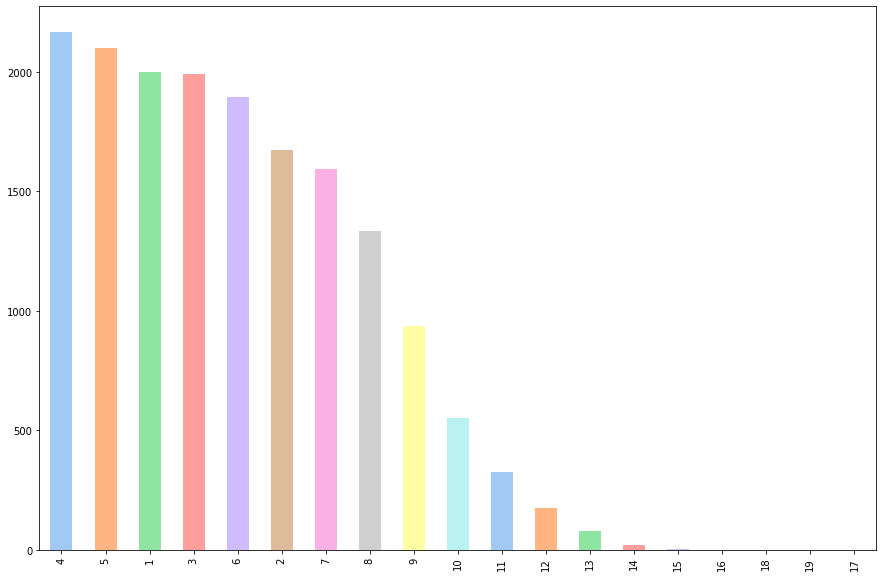

In [31]:
# Visualizing number of words in each sentences
plt.figure(figsize=(15,10))
ndf['word_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

<AxesSubplot:>

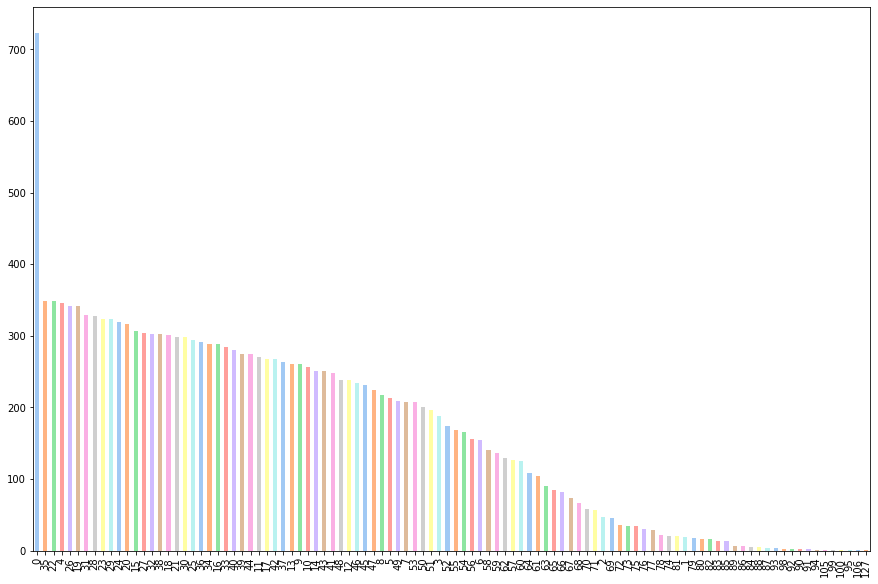

In [32]:
# Visualizing len of character of the strings in dataframe
ndf['char_count'] = ndf['correct_text'].str.len() # this also includes spaces
plt.figure(figsize=(15,10))
ndf['char_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

## Sentiment analysis and modeling

### 1. Using TextBlob

In [33]:
## sentiment analysis using textblob
TextBlob(ndf['correct_text'][3]).sentiment

Sentiment(polarity=-0.125, subjectivity=0.575)

- **Polarity:** It is a floating number that lies betwenn [-1,1]. closer to 1 means sentence is more positive while closer to -1 means sentense is more negative.

- **Subjectivity:** It is measure of someone's personal judgement or opinion. subjectivity close to 0 means it is a not a subjective statement while close to 1 means sentense is a subjective.

### 2. Using TfIDF vectorizer

In [34]:
X = ndf['correct_text']
y = ndf['oh_label']

# train and test split the dataset
X_trn, X_tst, y_trn, y_tst = train_test_split(X,y, random_state=42)
y_trn.value_counts(), y_tst.value_counts()

(0.0    8612
 1.0    4024
 Name: oh_label, dtype: int64,
 0.0    2889
 1.0    1323
 Name: oh_label, dtype: int64)

In [35]:
# tfidf object
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=5000)

In [36]:
# Vectorization using iftdf
X_trn_vect = tfidf.fit_transform(X_trn)
X_tst_vect = tfidf.transform(X_tst)

In [37]:
# converting sparse dataframe into pandas dataframe
x_t1 = pd.DataFrame(X_trn_vect.toarray(),columns=tfidf.get_feature_names())
x_t2 = pd.DataFrame(X_tst_vect.toarray(),columns=tfidf.get_feature_names())

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
x_t1.head()

,aberration,ability,able,able afford,able help,able make,able vote,abortion,absolute,absolutely,...,young,youve,youve got,yr,yuck,yummy,yummy food,yummy yummy,zero,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.496581,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# applying MultinomialNB algorithms
clf = MultinomialNB()
clf.fit(x_t1, y_trn)
pred = clf.predict(x_t2)

In [40]:
# LOG LOSS of the model
print("logloss: %0.3f " % log_loss(y_tst.values, pred))

logloss: 8.241 


### 3. Word2Vec

- Word2Vec is widely used in most of the NLP models. It transforms the word into vectors. Word2vec is a two-layer net that processes text with words. The input is in the text corpus and the output is a set of vectors: feature vectors represent the words on that corpus.

In [60]:
# word embeddings techniques using W2V 
class Word_to_Vect():
    '''Function that returns word embedding, if passed list of sentences and size of vector'''
    
    def __init__(self):
        pass
    
    def w2v(self, corpus, size):
        
        #tokenization and model preparation
        tokenize_sent = [sent.split() for sent in corpus]
        #creating vord2vec for every word in every sentence in corpus
        self.w2v = word2vec.Word2Vec(tokenize_sent, vector_size=size, min_count=1)
        
        return self.w2v
    
    def transform(self, X_corpus, size):
        
        array_wordEmbed = []
        for sent in X_corpus:
            vec = np.zeros(size).reshape((1, size))
            count = 0.
            if sent == '':
                a = vec
            else:
                sent = sent.split(' ')
                for word in sent:
                    vec += w2v[word].reshape((1,size))
                    count +=1
            if count !=0:
                vec /= count
            a = vec
            array_wordEmbed.append(a)
        return np.concatenate(tuple(array_wordEmbed))

In [61]:
w2v = Word_to_Vect().w2v(corpus = [sent for sent in X], size=len(X))

In [64]:
w2v.wv.similar_by_vector('history')

[('twitter', 0.9999960064888),
 ('woman', 0.9999958276748657),
 ('people', 0.999995768070221),
 ('get', 0.999995768070221),
 ('need', 0.999995768070221),
 ('see', 0.999995768070221),
 ('way', 0.9999957084655762),
 ('still', 0.9999957084655762),
 ('could', 0.9999957084655762),
 ('much', 0.9999957084655762)]

In [63]:
X_w2v = pd.DataFrame({word:w2v.wv[word] for sent in X for word in sent.split()})
X_w2v

,read,change,meaning,history,slavery,shreyabafna3,claim,people,tried,stop,...,prosecutor,delaying,reb,lorry,accomplishment,overdramatic,feat,apocalypse,rossbarnes9,pacify
0,0.002281,0.001057,0.000486,0.001150,0.001429,0.000058,0.001180,0.003090,0.000489,0.002463,...,0.000041,-0.000007,0.000082,0.000116,0.000021,0.000029,0.000027,0.000084,0.000046,-0.000004
1,-0.035848,-0.015495,-0.007412,-0.018041,-0.022029,-0.000589,-0.017119,-0.047799,-0.008130,-0.037504,...,-0.000751,-0.000710,-0.000469,-0.001009,-0.000596,-0.000282,-0.000558,-0.000470,-0.000183,-0.000781
2,-0.029755,-0.012780,-0.006229,-0.014987,-0.018318,-0.000460,-0.014249,-0.039617,-0.006801,-0.031140,...,-0.000696,-0.000619,-0.000384,-0.000818,-0.000498,-0.000226,-0.000566,-0.000408,-0.000182,-0.000626
3,-0.000611,-0.000310,-0.000080,-0.000353,-0.000354,0.000024,-0.000290,-0.000846,-0.000140,-0.000701,...,-0.000069,0.000020,-0.000062,-0.000064,0.000017,-0.000024,-0.000014,-0.000050,-0.000009,0.000043
4,-0.042245,-0.018174,-0.008727,-0.021139,-0.025925,-0.000674,-0.020216,-0.056164,-0.009623,-0.044078,...,-0.000928,-0.000848,-0.000463,-0.001147,-0.000697,-0.000379,-0.000733,-0.000616,-0.000272,-0.000966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16843,0.006047,0.002634,0.001281,0.002982,0.003747,0.000141,0.002920,0.008030,0.001362,0.006328,...,0.000153,0.000069,0.000094,0.000221,0.000054,0.000076,0.000140,0.000068,0.000032,0.000093
16844,-0.036060,-0.015439,-0.007477,-0.018028,-0.022237,-0.000519,-0.017232,-0.047886,-0.008130,-0.037570,...,-0.000850,-0.000724,-0.000382,-0.001024,-0.000541,-0.000318,-0.000593,-0.000519,-0.000200,-0.000810
16845,-0.013677,-0.005888,-0.002823,-0.006870,-0.008429,-0.000275,-0.006535,-0.018304,-0.003141,-0.014246,...,-0.000333,-0.000236,-0.000222,-0.000394,-0.000259,-0.000051,-0.000208,-0.000214,-0.000116,-0.000360
16846,-0.058590,-0.025208,-0.012217,-0.029375,-0.036065,-0.000892,-0.027998,-0.077959,-0.013260,-0.060996,...,-0.001254,-0.001113,-0.000689,-0.001558,-0.000870,-0.000393,-0.001052,-0.000837,-0.000309,-0.001368


In [65]:
# using xgboost and randomforest modeling
x_t1, x_t2, y_tr, y_ts = train_test_split(X_w2v, y, test_size=0.33, random_state=101)

In [70]:
xgb_model = XGBClassifier()
xgb_model.fit(x_t1, y_tr)
pred = xgb_model.predict(x_t2)

In [71]:
# evalute the loss of the model
print("logloss: %0.3f " % log_loss(y_ts, pred))

logloss: 12.008 


**Results:**

**1. We got log loss of 8.24 with tf-idf vectorization and multinomialNB projects.**

**2. We got log loss of 12 with XGBclassifier with W2V vectorization.**